In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
modelname="NASNetMobile_dropflatten"
LR=0.001
DO=0.2

In [3]:
foldernames_to_id={"VeryMildDemented":1, "NonDemented":0, "ModerateDemented":2, "MildDemented":3}
import os
import torch

In [4]:
from PIL import Image
from numpy import asarray
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers,models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.1) # set validation split

In [6]:
foldername='/content/drive/My Drive/ml_project/Dataset/'
train_images = train_datagen.flow_from_directory(
    foldername,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_images = train_datagen.flow_from_directory(
    foldername , # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.


In [8]:
def create_model():
  mymodel = Sequential()

  pretrained_model= tf.keras.applications.NASNetMobile(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
  for layer in pretrained_model.layers:
        layer.trainable=False

  mymodel.add(pretrained_model)

  mymodel.add(Flatten())
  mymodel.add(Dropout(DO))
  mymodel.add(Dense(256, activation='relu'))
  mymodel.add(Dropout(DO))
  mymodel.add(Dense(4, activation='softmax'))
  mymodel.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=LR), metrics = ['accuracy'])
  return mymodel

In [9]:
# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

19993432/19993432 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 1056)              4269716   
                                                                 
 flatten (Flatten)           (None, 1056)              0         
                                                                 
 dropout (Dropout)           (None, 1056)              0         
                                                                 
 dense (Dense)               (None, 256)               270592    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
# Include the epoch in the file name (uses `str.format`)
checkpointdir='/content/drive/My Drive/ml_project/Checkpoints/'
checkpoint_path = checkpointdir+modelname+"-training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=20*batch_size)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

In [11]:
# Evaluate the model
#loss, acc = model.evaluate(validation_images, verbose=2)
#print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

In [12]:
history = model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=150,
    callbacks=[cp_callback])

Epoch 1/150
639/956 [===================>..........] - ETA: 52:36 - loss: 1.0893 - accuracy: 0.5044
Epoch 1: saving model to /content/drive/My Drive/ml_project/Checkpoints/NASNetMobile_dropflatten-training/cp-0001.ckpt
956/956 [==============================] - 10442s 11s/step - loss: 1.0493 - accuracy: 0.5200 - val_loss: 0.9310 - val_accuracy: 0.5756
Epoch 2/150
323/956 [=========>....................] - ETA: 48s - loss: 0.9107 - accuracy: 0.5815
Epoch 2: saving model to /content/drive/My Drive/ml_project/Checkpoints/NASNetMobile_dropflatten-training/cp-0002.ckpt
956/956 [==============================] - 82s 86ms/step - loss: 0.8933 - accuracy: 0.5898 - val_loss: 0.7723 - val_accuracy: 0.6457
Epoch 3/150
  7/956 [..............................] - ETA: 1:16 - loss: 0.8712 - accuracy: 0.5759
Epoch 3: saving model to /content/drive/My Drive/ml_project/Checkpoints/NASNetMobile_dropflatten-training/cp-0003.ckpt
647/956 [===================>..........] - ETA: 24s - loss: 0.8367 - accuracy:

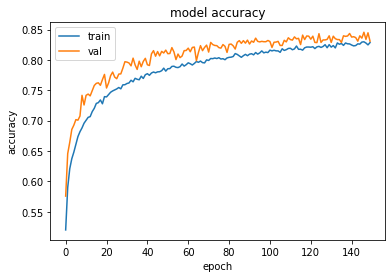

In [13]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

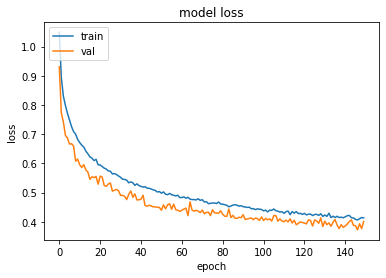

In [14]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2 following cells are for loading latest trained models

In [15]:
# Create a basic model instance
#model = create_model()

# Evaluate the model
#loss, acc = model.evaluate(validation_images, verbose=2)
#print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

In [16]:
# Loads the weights
#p = checkpointdir+modelname+"-training/cp-"

#fill in the best model filename like 0004
#best_checkpoint_path=p+""+"".ckpt"
#latest = tf.train.latest_checkpoint(checkpoint_dir)
#model.load_weights(latest)

# Re-evaluate the model
#loss, acc = model.evaluate(validation_images, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))